In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [218]:
import json
import ast
import itertools
import os
import argparse
import pickle

from PIL import Image
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib
# matplotlib.use('Agg')
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('poster')
sns.set()

from shared_astro_utils import plotting_utils

from zoobot.estimators import input_utils
from zoobot.active_learning import metrics, simulation_timeline, analysis

from zoobot.tfrecord import read_tfrecord
from zoobot.tests import TEST_FIGURE_DIR

In [219]:
!pwd

/Data/repos/zoobot/notebooks


### Define Records to Load

In [220]:
shard_dir = '/Volumes/alpha/uint8_128px_bar_n'

In [339]:
oracle = pd.read_csv(
    os.path.join(shard_dir, 'oracle.csv'), 
    usecols=['id_str', 'label', 'total_votes'],
    dtype={'id_str': str, 'label': int, 'total_votes': int}
)

In [353]:
catalog = pd.read_csv(os.path.join(shard_dir, 'full_catalog.csv'))
catalog['id_str'] = catalog['id'].astype(str)
catalog['label'] = catalog['t03_bar_a06_bar_count']

In [378]:
assert len(catalog) == len(oracle)
assert all(catalog['label'] == oracle['label'])
assert all(catalog['id_str'] == oracle['id_str'])
assert all(catalog['total_votes'] == oracle['total_votes'])

In [380]:
catalog[['label', 'total_votes', 'bar_total-votes', 'file_loc']].head(10)

,label,total_votes,bar_total-votes,file_loc
0,1,40,40,/Volumes/alpha/gz2/png/587732/5877325917148938...
1,4,41,41,/Volumes/alpha/gz2/png/588009/5880093685459846...
2,0,32,32,/Volumes/alpha/gz2/png/587731/5877318707085968...
3,4,18,18,/Volumes/alpha/gz2/png/587736/5877365463112746...
4,5,49,49,/Volumes/alpha/gz2/png/587733/5877330818864907...
5,11,37,37,/Volumes/alpha/gz2/png/587739/5877398292744110...
6,0,13,13,/Volumes/alpha/gz2/png/587736/5877367820021926...
7,0,42,42,/Volumes/alpha/gz2/png/588018/5880180567331308...
8,36,37,37,/Volumes/alpha/gz2/png/587742/5877426161737401...
9,37,45,45,/Volumes/alpha/gz2/png/587733/5877336042671311...


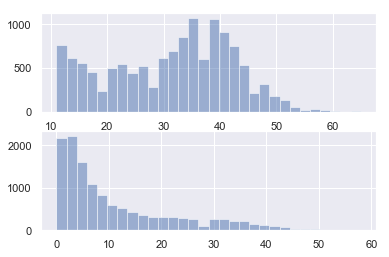

In [383]:
fig, (ax0, ax1) = plt.subplots(nrows=2)
_ = ax0.hist(catalog['total_votes'], bins=30, alpha=.5)

_ = ax1.hist(catalog['label'], bins=30, alpha=.5)

In [277]:
train_dir = os.path.join(shard_dir, 'train_shards')
training_locs = [os.path.join(train_dir, x) for x in os.listdir(train_dir) if x.endswith('.tfrecord')]

In [275]:
iteration_dir = '../data/runs/al_baseline_test/iteration_1'
tfrecord_dir = os.path.join(iteration_dir, 'acquired_tfrecords')
acquired_locs = [os.path.join(tfrecord_dir, loc) for loc in os.listdir(tfrecord_dir)]

### Check that labels are recorded correctly, measured via id_strs and catalog

In [279]:
_ = analysis.verify_tfrecord_matches_catalog(training_locs, catalog)
_ = analysis.verify_tfrecord_matches_catalog(acquired_locs, catalog)

### Compare Distributions of Labels, Total Votes

In [303]:
size = 128
channels = 3
n_subjects = None

training_subjects = read_tfrecord.load_examples_from_tfrecord(
    training_locs, 
    read_tfrecord.custom_feature_spec(['id_str', 'label', 'count']),
    n_examples=n_subjects)

acquired_subjects = read_tfrecord.load_examples_from_tfrecord(
    acquired_locs, 
    read_tfrecord.custom_feature_spec(['id_str', 'label', 'count']),
    n_examples=n_subjects)

In [304]:
len(training_subjects), len(acquired_subjects)

(4800, 6000)

In [305]:
def unpack(subjects):
    labels = [s['label'] for s in subjects]
    total_votes = [s['total_votes'] for s in subjects]
    id_strs = [s['id_str'].decode('utf-8') for s in subjects]
    return labels, total_votes, id_strs

In [306]:
training_labels, training_total_votes, training_id_strs = unpack(training_subjects)
acquired_labels, acquired_total_votes, acquired_id_strs = unpack(acquired_subjects)

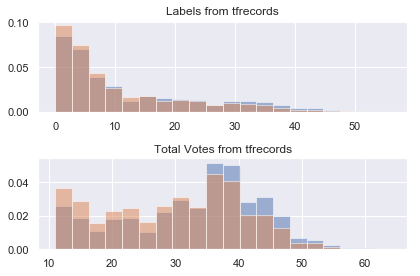

In [387]:
fig, (ax0, ax1) = plt.subplots(nrows=2)
_, bins, _ = ax0.hist(training_labels, bins=20, density=True, alpha=0.5)
_ = ax0.hist(acquired_labels, bins=bins[:-1], density=True, alpha=0.5)
ax0.set_title('Labels from tfrecords')

_, bins, _ = ax1.hist(training_total_votes, bins=20, density=True, alpha=0.5)
_ = ax1.hist(acquired_total_votes, bins=bins[:-1], density=True, alpha=0.5)
ax1.set_title('Total Votes from tfrecords')

fig.tight_layout()

### Check There Are No Duplicates

In [309]:
# no duplicates within train, or within acquired
assert len(training_id_strs) == len(set(training_id_strs))
assert len(acquired_id_strs) == len(set(acquired_id_strs))
# no duplicates shared between training and acquired
assert set(training_id_strs) - set(acquired_id_strs) == set(training_id_strs)
assert set(acquired_id_strs) - set(training_id_strs) == set(acquired_id_strs)

### Load images from all records

In [403]:
size = 128
channels = 3
n_subjects = None

training_subjects = read_tfrecord.load_examples_from_tfrecord(
    training_locs, 
    read_tfrecord.custom_feature_spec(['matrix', 'id_str', 'label', 'count']),
    n_examples=n_subjects)
training_images = np.array([subject['matrix'].astype(np.uint8).reshape(size, size, channels) for subject in training_subjects])

acquired_subjects = read_tfrecord.load_examples_from_tfrecord(
    acquired_locs, 
    read_tfrecord.custom_feature_spec(['matrix', 'id_str', 'label', 'count']),
    n_examples=n_subjects)
acquired_images = np.array([subject['matrix'].astype(np.uint8).reshape(size, size, channels) for subject in acquired_subjects])

### Check Dimensions and Values of Images are Similar

In [313]:
training_images.shape, acquired_images.shape

((4800, 128, 128, 3), (6000, 128, 128, 3))

In [314]:
training_images.mean(), acquired_images.mean()

(10.231013882954915, 9.578879357231989)

(array([1.175e+03, 6.490e+02, 4.790e+02, 3.800e+02, 3.030e+02, 2.550e+02,
        2.070e+02, 1.290e+02, 8.200e+01, 5.500e+01, 3.500e+01, 1.900e+01,
        1.400e+01, 1.000e+01, 3.000e+00, 5.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00]),
 array([ 16.  ,  27.95,  39.9 ,  51.85,  63.8 ,  75.75,  87.7 ,  99.65,
        111.6 , 123.55, 135.5 , 147.45, 159.4 , 171.35, 183.3 , 195.25,
        207.2 , 219.15, 231.1 , 243.05]),
 <a list of 19 Patch objects>)

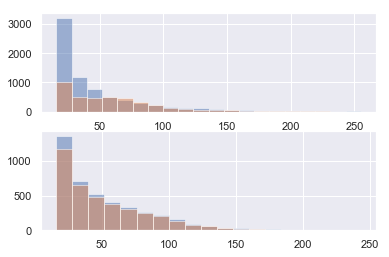

In [322]:
fig, (ax0, ax1) = plt.subplots(nrows=2)
min_clip = 15
flat_training_image = np.ravel(training_images[0])
_, bins, _ = ax0.hist(flat_training_image[flat_training_image > min_clip], bins=20, alpha=0.5)
flat_acquired_image = np.ravel(acquired_images[0])
ax0.hist(flat_acquired_image[flat_acquired_image > min_clip], bins=bins[:-1], alpha=0.5)

flat_training_batch = np.ravel(np.mean(training_images, axis=0))
ax1.hist(flat_training_batch[flat_training_batch > min_clip], bins=bins[:-1], alpha=0.5)
flat_acquired_batch = np.ravel(np.mean(acquired_images, axis=0))
ax1.hist(flat_acquired_batch[flat_acquired_batch > min_clip], bins=bins[:-1], alpha=0.5)

### Visualise Subjects From All Records

In [436]:
n_rows = 6
n_cols = 6
training_label_strs = ['k: {}, N: {}, ID: {}'.format(s['label'], s['total_votes'], s['id_str'].decode('utf-8')) for s in training_subjects]
acquired_label_strs = ['k: {}, N: {}, ID: {}'.format(s['label'], s['total_votes'], s['id_str'].decode('utf-8')) for s in acquired_subjects]
assert training_label_strs != acquired_label_strs

plotting_utils.plot_galaxy_grid(training_images, n_rows, n_cols, 'grid_training.png', labels=training_label_strs)
plotting_utils.plot_galaxy_grid(acquired_images, n_rows, n_cols, 'grid_acquired.png', labels=acquired_label_strs)

#### Check that subjects match images on disk

In [453]:
def compare_disk_and_tfrecord(catalog, subjects, id_str):
    fig, (ax0, ax1) = plt.subplots(ncols=2)

    # look up id in catalog and show png in file_loc
    subject_disk = catalog[catalog['id_str'] == id_str].squeeze()
    file_loc = subject_disk['file_loc']
    pil_im = Image.open(file_loc, 'r')
    ax0.imshow(np.asarray(pil_im))
    ax0.set_title('Disk')
    ax0.grid(False)

    # look up id in tfrecord and show saved matrix
    matching_tf = [x for x in subjects if x['id_str'].decode('utf-8') == id_str]
    assert len(matching_tf) == 1
    subject_tfrecord = matching_tf[0]
    image = subject_tfrecord['matrix'].astype(np.uint8).reshape(size, size, channels)
    ax1.set_title('tfrecord')
    ax1.imshow(image)
    ax1.grid(False)

    assert subject_disk['total_votes'] == subject_tfrecord['total_votes']
    assert subject_disk['label'] == subject_tfrecord['label']

    print(subject_disk['label'], subject_disk['total_votes'])

Training:

0 15


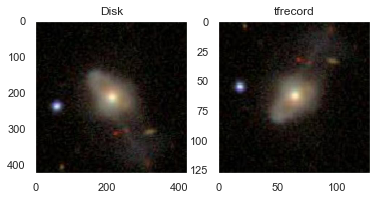

In [454]:
compare_disk_and_tfrecord(catalog, training_subjects, '154311')

3 32


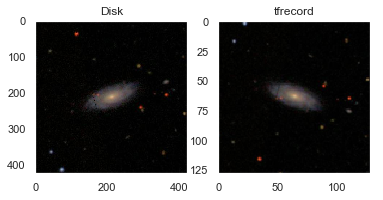

In [455]:
compare_disk_and_tfrecord(catalog, training_subjects, '237731')

Acquired:

50 50


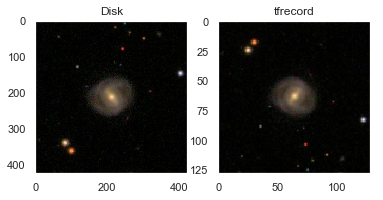

In [456]:
compare_disk_and_tfrecord(catalog, training_subjects, '164147')

6 47


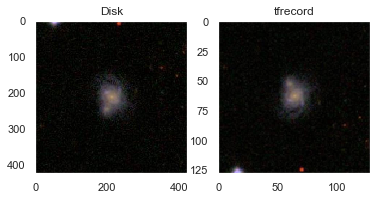

In [457]:
compare_disk_and_tfrecord(catalog, acquired_subjects, '287360')